## RNN Time Series Classification

### Importing Required Libraries and Data

In [4]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Masking, Dropout, SimpleRNN
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
os.chdir('../Data/CMaps')

In [5]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_train['failure_lbl_1'] = [1 if i < 50 else 0 for i in df_train.RUL]
    df_train['failure_lbl_2'] = df_train['failure_lbl_1']
    df_train['failure_lbl_2'] = np.where(df_train.RUL < 25, 2, df_train['failure_lbl_2'])
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    y_true['failure_lbl_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
    y_true['failure_lbl_2'] = y_true['failure_lbl_1']
    y_true['failure_lbl_2'] = np.where(y_true.RUL < 25, 2, y_true['failure_lbl_2'])    
    return df_train, df_test, y_true

In [6]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 20), (13096, 17), (100, 4))

In [7]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])

In [8]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [9]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure_lbl_1,failure_lbl_2
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0,0


In [10]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [11]:
y_true.head()

,RUL,UnitNumber,failure_lbl_1,failure_lbl_2
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [12]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [13]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [14]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

### Function to Print results

In [15]:
def print_results(y_test, y_pred, multi_class=False):    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d", annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area under curve : ", model_roc_auc, "\n")
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix], 3)
        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

## Binary Classification

In [16]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_1"


Let's prepare data using above functions.

In [17]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [18]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [19]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [20]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [21]:
nb_features = x_train.shape[2]
nb_out = 1

In [22]:
nb_features

15

In [23]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(2)}
cls_wt

{0: 0.7329699002888826, 1: 1.5731}

### Model

In [28]:
history = History()
model = Sequential()
model.add(SimpleRNN(32, input_shape=(sequence_length, nb_features), activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1536      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,809
Trainable params: 1,809
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, class_weight=cls_wt,
          callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')])

Epoch 1/100
197/197 [==============================] - 13s 65ms/step - loss: 0.2869 - accuracy: 0.8949 - val_loss: 0.2185 - val_accuracy: 0.9075
Epoch 2/100
197/197 [==============================] - 12s 62ms/step - loss: 0.1918 - accuracy: 0.9236 - val_loss: 0.2297 - val_accuracy: 0.9024
Epoch 3/100
197/197 [==============================] - 12s 62ms/step - loss: 0.1701 - accuracy: 0.9278 - val_loss: 0.2745 - val_accuracy: 0.8834
Epoch 4/100
197/197 [==============================] - 12s 63ms/step - loss: 0.1429 - accuracy: 0.9387 - val_loss: 0.2053 - val_accuracy: 0.9161
Epoch 5/100
197/197 [==============================] - 13s 64ms/step - loss: 0.1422 - accuracy: 0.9426 - val_loss: 0.1970 - val_accuracy: 0.9139
Epoch 6/100
197/197 [==============================] - 13s 64ms/step - loss: 0.1229 - accuracy: 0.9510 - val_loss: 0.2190 - val_accuracy: 0.9101
Epoch 7/100
197/197 [==============================] - 12s 63ms/step - loss: 0.1188 - accuracy: 0.9510 - val_loss: 0.2212 - val_ac

Text(0.5, 1.0, 'Loss')

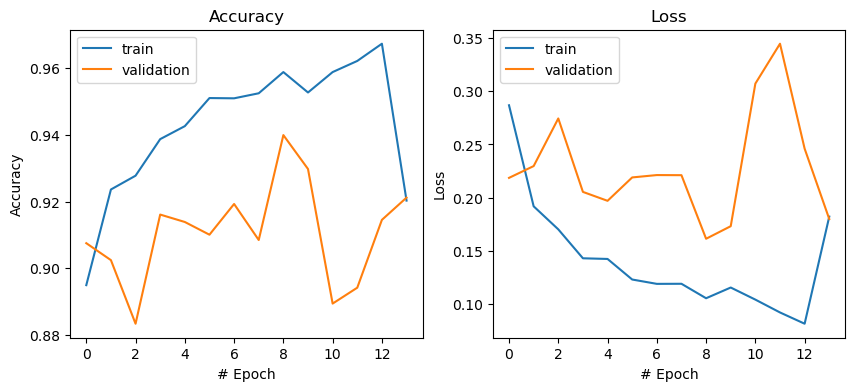

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 0s 27ms/step
F1 Score:  0.9523809523809523
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        70
           1       0.91      1.00      0.95        30

    accuracy                           0.97       100
   macro avg       0.95      0.98      0.97       100
weighted avg       0.97      0.97      0.97       100

Area under curve :  0.9785714285714286 



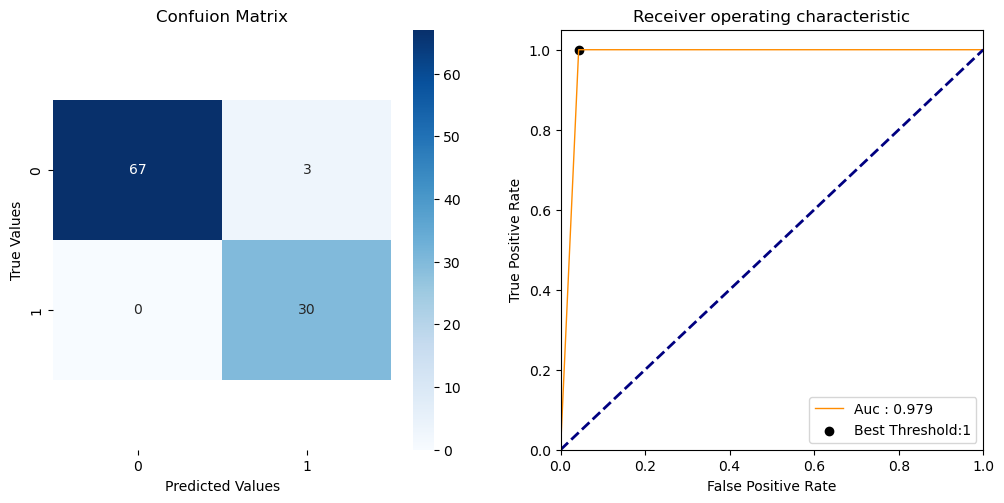

In [31]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure_lbl_1, y_pred)

In [32]:
confusion_matrix(y_train, (model.predict(x_train) > 0.5).astype("int32"))

492/492 [==============================] - 6s 13ms/step


array([[10312,   419],
       [  398,  4602]])

## Multiclass Classification

In [33]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_2"


Let's prepare data using above functions.

In [34]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [35]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [36]:
y_train2 = to_categorical(y_train)
y_train2

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [37]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [38]:
nb_features = x_train.shape[2]
nb_out = y_train2.shape[1]

In [39]:
nb_features, nb_out

(15, 3)

In [40]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(3)}
cls_wt

{0: 0.48864660019258843, 1: 2.0974666666666666, 2: 2.0974666666666666}

### Model

In [41]:
history2 = History()
model2 = Sequential()
model2.add(SimpleRNN(32, input_shape=(sequence_length, nb_features), activation = 'relu'))
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(units=nb_out, activation='softmax'))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1536      
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 1,827
Trainable params: 1,827
Non-trainable params: 0
_________________________________________________________________


In [42]:
%%time
# fit the model
model2.fit(x_train, y_train2, epochs=10, batch_size=64, validation_split=0.2, verbose=1, class_weight=cls_wt,
           callbacks=[history2, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/10
197/197 [==============================] - 13s 61ms/step - loss: 0.8203 - accuracy: 0.7707 - val_loss: 0.4048 - val_accuracy: 0.8071
Epoch 2/10
197/197 [==============================] - 12s 60ms/step - loss: 0.4915 - accuracy: 0.8154 - val_loss: 0.3889 - val_accuracy: 0.8058
Epoch 3/10
197/197 [==============================] - 12s 60ms/step - loss: 0.4101 - accuracy: 0.8356 - val_loss: 0.5150 - val_accuracy: 0.7687
Epoch 4/10
197/197 [==============================] - 12s 60ms/step - loss: 0.3736 - accuracy: 0.8468 - val_loss: 0.2969 - val_accuracy: 0.8573
Epoch 5/10
197/197 [==============================] - 12s 59ms/step - loss: 0.3596 - accuracy: 0.8533 - val_loss: 0.3003 - val_accuracy: 0.8586
Epoch 6/10
197/197 [==============================] - 12s 60ms/step - loss: 0.3578 - accuracy: 0.8632 - val_loss: 0.2929 - val_accuracy: 0.8777
Epoch 7/10
197/197 [==============================] - 12s 60ms/step - loss: 0.3455 - accuracy: 0.8721 - val_loss: 0.3011 - val_accuracy:

Text(0.5, 1.0, 'Loss')

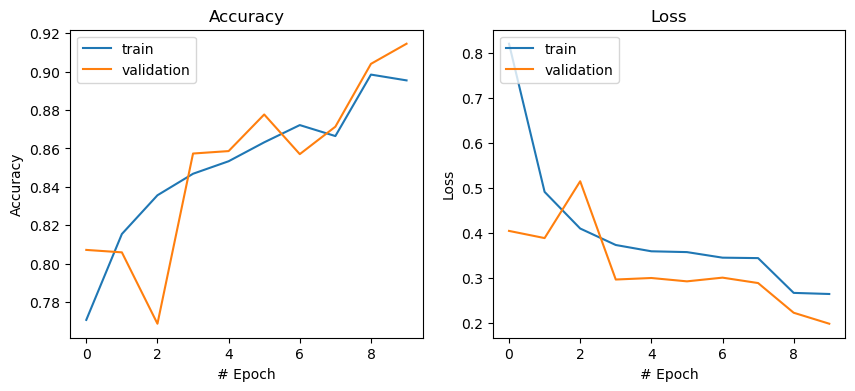

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history2.history['accuracy'])
ax[0].plot(history2.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 0s 21ms/step
F1 Score:  0.812467015791824
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        70
           1       0.53      0.82      0.64        11
           2       0.93      0.74      0.82        19

    accuracy                           0.90       100
   macro avg       0.82      0.84      0.81       100
weighted avg       0.93      0.90      0.91       100



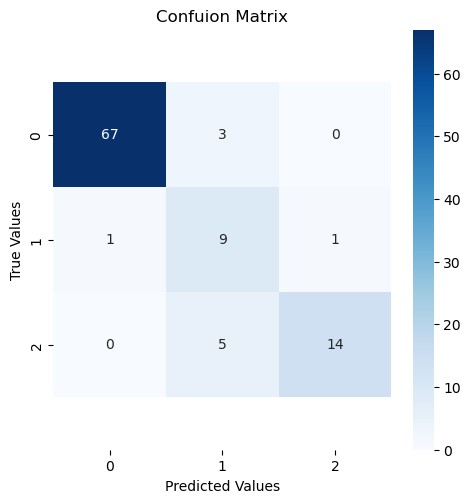

In [44]:
y_pred = np.argmax(model2.predict(x_test), axis=-1)
print_results(y_true.failure_lbl_2, y_pred, multi_class=True)

In [45]:
confusion_matrix(y_train, np.argmax(model2.predict(x_train), axis=-1))

492/492 [==============================] - 6s 13ms/step


array([[10317,   414,     0],
       [  463,  1916,   121],
       [    0,   237,  2263]])